<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "1B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/1B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


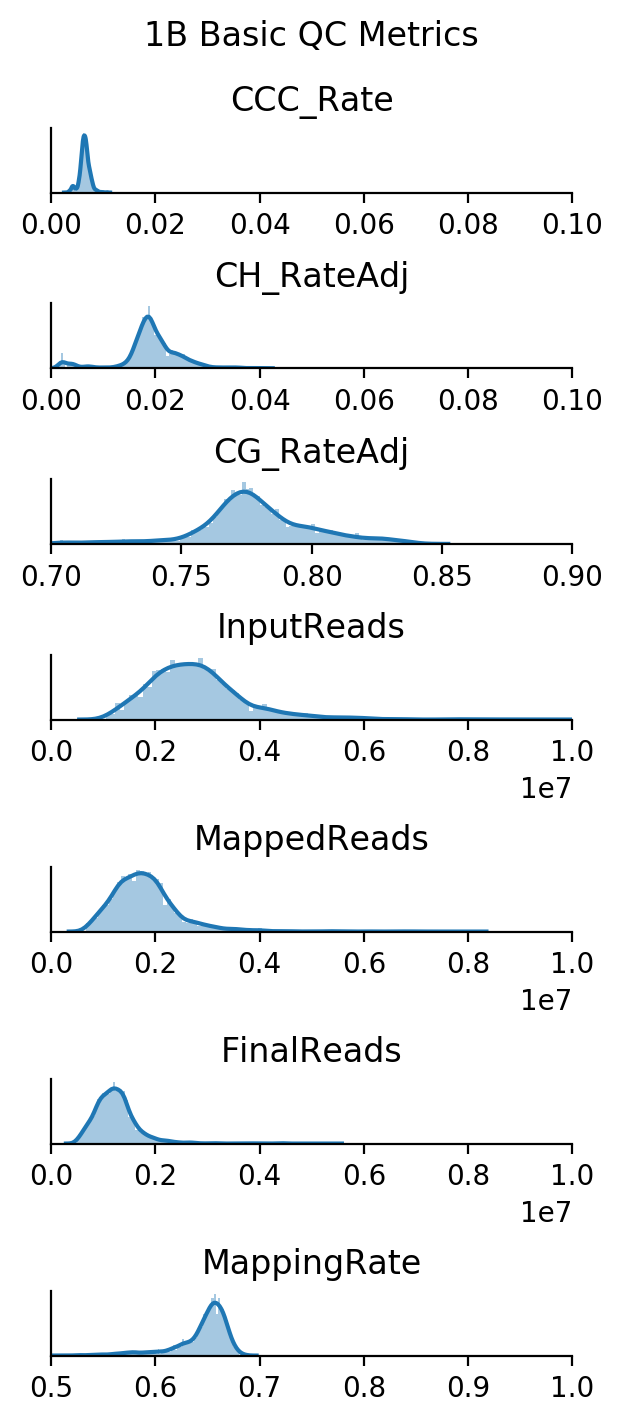

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

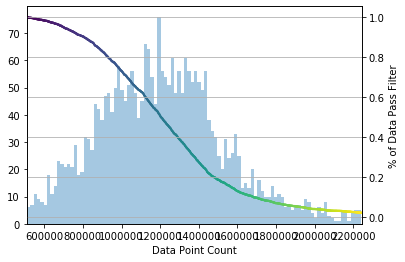

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2736/2736 (100.0%)
CG_RateAdj passed 2736/2736 (100.0%)
CH_RateAdj passed 2736/2736 (100.0%)
FinalReads passed 2736/2736 (100.0%)
MappingRate passed 2736/2736 (100.0%)
Overall passed 2736/2736 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180119 1373
180213 1363


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 333 86.7%
ad002 340 88.5%
ad004 337 87.8%
ad006 338 88.0%
ad007 345 89.8%
ad008 346 90.1%
ad010 350 91.1%
ad012 347 90.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
1B_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00820,0.81452,0.81299,0.03726,0.02930,741041.0,1548906,993172.0,1B,...,-24.012169,1.915018,-41.669810,-3.996634,MGE-Sst Frmd6,4.894039,-12.386347,-20.899007,18.955992,True
1B_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00776,0.84041,0.83916,0.03075,0.02317,695659.0,1438892,943715.0,1B,...,26.240360,0.730589,-3.842909,-40.719041,NP-L6 Kcnab1,7.650445,-6.107613,10.654132,16.853810,True
1B_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00679,0.78073,0.77923,0.02534,0.01868,992699.0,2102986,1378234.0,1B,...,8.812142,-11.267000,10.121543,17.099969,IT-L5 Cdh8,1.597970,7.309331,16.078213,-7.351818,True
1B_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00666,0.78113,0.77966,0.02545,0.01892,1358928.0,2985056,1984409.0,1B,...,3.498479,-9.167920,-16.887460,8.920904,IT-L23 Ptprt,-2.311957,1.457496,-12.149784,8.853756,True
1B_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00692,0.79747,0.79606,0.03149,0.02474,965357.0,2009342,1302650.0,1B,...,-26.697559,5.401599,7.107803,-25.735417,MGE-Pvalb Thsd7a,-2.062156,-5.553045,12.869260,-12.756714,True
1B_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00699,0.79215,0.79069,0.02849,0.02165,988506.0,2070024,1342322.0,1B,...,12.281812,-11.780973,18.723835,16.829743,IT-L5 Etv1,6.932877,1.677813,-6.286166,15.136241,True
1B_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00700,0.80341,0.80202,0.02871,0.02186,1067955.0,2244440,1455211.0,1B,...,25.193214,6.226488,-15.933507,-18.824642,CT-L6 Tnr,-5.289258,-23.405483,-29.642639,-3.985747,True
1B_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00733,0.77444,0.77277,0.02861,0.02144,1021159.0,2396388,1409255.0,1B,...,4.785825,-8.157956,-13.214512,3.591577,IT-L23 Ptprt,-3.182488,-0.254582,-23.414647,13.401158,True
1B_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00729,0.80781,0.80640,0.03121,0.02410,1948017.0,4052688,2726469.0,1B,...,11.639434,-11.919219,18.318035,15.958659,IT-L5 Etv1,5.220471,2.792172,-4.404511,11.755423,True
1B_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.00790,0.77519,0.77340,0.03396,0.02627,947212.0,2054668,1321282.0,1B,...,13.816600,-9.756134,29.718589,8.884590,IT-L5 Grik3,6.453181,-2.452775,-7.990957,41.057797,True
